In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd

from itertools import cycle
from pathlib import Path
from plot_style import *

from balanced_topo import balanced_tree_with_fixed_leaves

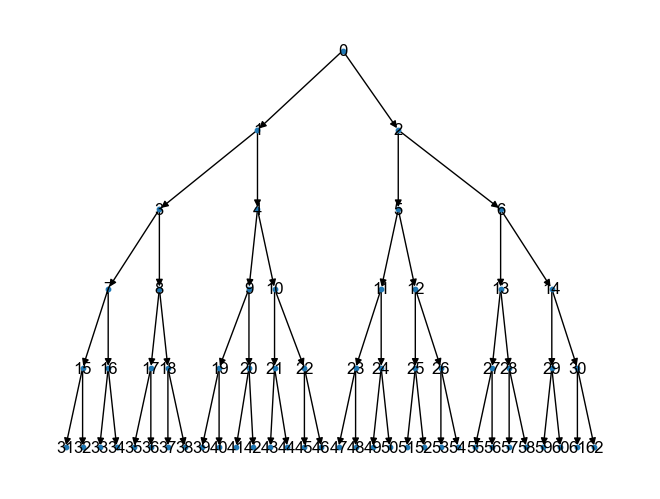

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tree = nx.balanced_tree(2, 5, create_using=nx.DiGraph)
    pos = nx.nx_pydot.pydot_layout(tree, prog="dot")
    nx.draw(tree, pos=pos, node_size=10, with_labels=True)
    plt.show()

# Two-Tier Communication Costs
We want to consider what the *"true"* communication costs are for transmitting models over a network. By "true" communication costs, we mean the cost of transmitting the model across all the intermediate hops required to get from the coordinator to the workers and vice versa.

In two-tier FL, while the considered network may seem like it only consists of the coordinator and the flat tier of workers, this may be far removed from the true underlying network topology.

To this end, we compare the cost of two-tier FL where each worker sends their weights back to the coordinator versus hierarchical FL where the intermediate aggregators aggregate along the way back to the coordinator.

In [3]:
def compute_two_tier_cost(tree: nx.DiGraph, root, model_size_mb: float) -> float:
    assert len(list(tree.predecessors(root))) == 0

    workers = []
    cost = 0
    for node in tree.nodes():
        successors = list(tree.successors(node))
        if len(successors) == 0:
            workers.append(node)

    # Calculate broadcast.
    cost += tree.number_of_edges() * model_size_mb

    # Calculate response.
    for w in workers:
        num_hops = nx.shortest_path_length(tree, source=root, target=w)
        cost += num_hops * model_size_mb

    return cost


def compute_hierarchical_cost(tree: nx.DiGraph, root, model_size_mb: float) -> float:
    assert len(list(tree.predecessors(root))) == 0
    edges = tree.number_of_edges()
    return 2 * edges * model_size_mb


In [4]:
compute_two_tier_cost(tree, 0, 230), compute_hierarchical_cost(tree, 0, 230)

(51060, 28520)

In [5]:
models = ["SqueezeNet", "ResNet-18", "ResNet-34", "ResNet-50", "ResNet-101", "ResNet-152"]
model_sizes = [4.762, 44.629, 83.217, 97.695, 170.344, 230.196]

In [6]:
trees = []
heights = [1, 2, 4, 8]
for h in heights:
    t = balanced_tree_with_fixed_leaves(256, h)
    trees.append(t)

trees

In [7]:
records = []
for m in range(len(models)):
    model = models[m]
    size = model_sizes[m]
    for tree, h in zip(trees, heights):
        c = compute_two_tier_cost(tree, 0, size)
        print(c, 2 * h * 256 * size)
        records.append({
            "cost_mb": c,
            "cost_gb": c / 1024,
            "cost_kind": "two_tier",
            "height": h,
            "model": model,
            "model_size_mb": size,
            "model_size_gb": size / 1024,
        })

        c = compute_hierarchical_cost(tree, 0, size)
        records.append({
            "cost_mb": c,
            "cost_gb": c / 1024,
            "cost_kind": "hierarchical",
            "height": h,
            "model": model,
            "model_size_mb": size,
            "model_size_gb": size / 1024,
        })

comm_df = pd.DataFrame.from_records(records)
comm_df = comm_df.replace({"hierarchical": "Hier.", "two_tier": "2-Tier"})
comm_df.head()

2438.144000000004 2438.144
3733.4079999999713 4876.288
6495.367999999948 9752.576
12181.195999999905 19505.152
22850.048000000206 22850.048
34989.136000000326 45700.096
60873.95600000048 91400.192
114160.9820000008 182800.384
42607.10399999971 42607.104
65242.12800000028 85214.208
113507.9880000005 170428.416
212869.08600000088 340856.832
50019.839999999924 50019.84
76592.87999999986 100039.68
133255.97999999972 200079.36
249903.80999999942 400158.72
87216.12799999931 87216.128
133549.69599999904 174432.256
232349.21599999873 348864.512
435739.9519999978 697729.024
117860.35199999926 117860.352
180473.6640000002 235720.704
313987.34400000115 471441.408
588841.3680000029 942882.816


,cost_mb,cost_gb,cost_kind,height,model,model_size_mb,model_size_gb
0,2438.144,2.381000,2-Tier,1,SqueezeNet,4.762,0.00465
1,2438.144,2.381000,Hier.,1,SqueezeNet,4.762,0.00465
2,3733.408,3.645906,2-Tier,2,SqueezeNet,4.762,0.00465
3,2590.528,2.529812,Hier.,2,SqueezeNet,4.762,0.00465
4,6495.368,6.343133,2-Tier,4,SqueezeNet,4.762,0.00465


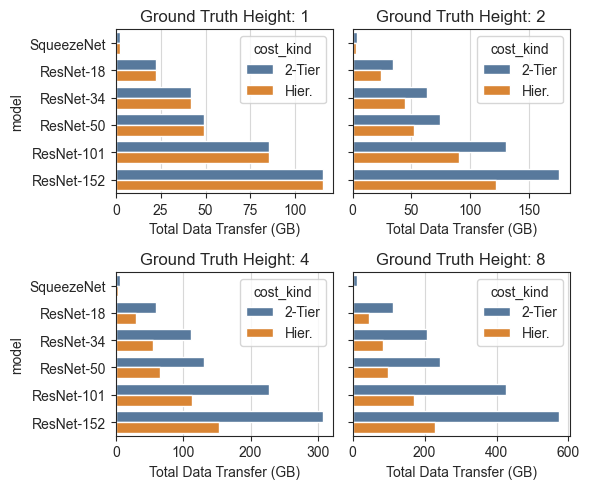

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 5), sharey=True)
for idx in range(4):
    i = idx // 2
    j = idx % 2

    ax = axes[i, j]
    height = heights[idx]
    sns.barplot(
        comm_df.query(f"height == {height}"),
        y="model",
        x="cost_gb",
        hue="cost_kind",
        ax=ax
    )

    ax.set_xlabel("Total Data Transfer (GB)")
    ax.set_title(f"Ground Truth Height: {height}")

plt.tight_layout()
plt.savefig("comm_cost_hier_vs_stand.pdf", bbox_inches="tight")
plt.show()

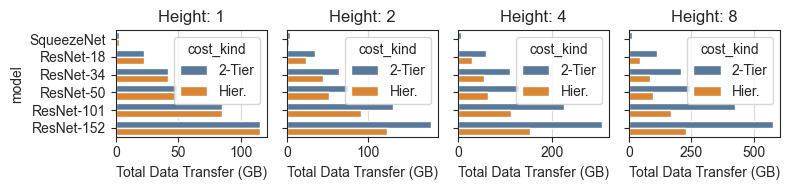

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 2), sharey=True)
for idx in range(4):
    i = idx // 2
    j = idx % 2

    ax = axes[idx]
    height = heights[idx]
    sns.barplot(
        comm_df.query(f"height == {height}"),
        y="model",
        x="cost_gb",
        hue="cost_kind",
        ax=ax
    )

    ax.set_xlabel("Total Data Transfer (GB)")
    ax.set_title(f"Height: {height}")

plt.tight_layout()
plt.savefig("comm_cost_hier_vs_stand_row.pdf", bbox_inches="tight")
plt.show()

In [10]:
data_dir = Path("out/2024-03-28__01:30:50")
data_dir

PosixPath('out/2024-03-28__01:30:50')

In [11]:
files = list(data_dir.glob("*.feather"))
files

[PosixPath('out/2024-03-28__01:30:50/height=2__workers=256.feather'),
 PosixPath('out/2024-03-28__01:30:50/height=8__workers=256.feather'),
 PosixPath('out/2024-03-28__01:30:50/height=4__workers=256.feather'),
 PosixPath('out/2024-03-28__01:30:50/height=1__workers=256.feather')]

In [12]:
acc_df = pd.concat([pd.read_feather(f) for f in files])
acc_df = acc_df.replace({"fedsgd": "FedSGD", "fedavg": "FedAvg", "fedprox": "FedProx"})
acc_df.head()

,train/acc,train/loss,train/epoch,train/batch_idx,train/time,node/idx,node/kind,parent/idx,parent/kind,round,test/acc,test/loss,train/rel_time,strategy,height,workers
0,0.03125,2.298315,0,0,2024-03-28 01:51:57.965042,162,worker,10,aggregator,0,0.1,2.305933,3.592713,FedAvg,2,256
1,0.21875,2.294145,0,1,2024-03-28 01:51:57.996296,162,worker,10,aggregator,0,0.1,2.305933,3.623967,FedAvg,2,256
2,0.18750,2.289414,0,2,2024-03-28 01:51:58.026428,162,worker,10,aggregator,0,0.1,2.305933,3.654099,FedAvg,2,256
3,0.00000,2.361361,0,3,2024-03-28 01:51:58.034166,162,worker,10,aggregator,0,0.1,2.305933,3.661837,FedAvg,2,256
4,0.21875,2.289307,1,0,2024-03-28 01:51:58.066558,162,worker,10,aggregator,0,0.1,2.305933,3.694229,FedAvg,2,256


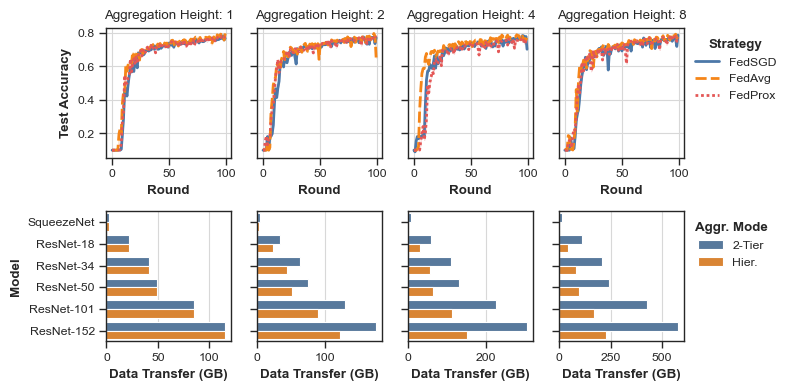

In [13]:
with sns.plotting_context("paper", font_scale=1):
    nrows, ncols = 2, 4
    order = ["FedSGD", "FedAvg", "FedProx"]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 4), sharey="row")

    ############################################################
    # ROW 1: Accuracy curves.
    i = 0
    for j in range(ncols):
        h = int(2 ** j)
        sns.lineplot(
            acc_df.query(f"height == {h}"),
            x="round",
            y="test/acc",
            hue="strategy",
            style="strategy",
            hue_order=order,
            style_order=order,
            linewidth=2,
            ax=axes[i, j],
        )
        axes[i, j].set_xlabel("Round", weight="bold")
        axes[i, j].set_title(f"Aggregation Height: {h}")
        if j == ncols - 1:
            # legend = axes[i, j].legend(frameon=False, title="Strategy")
            legend = axes[i, j].legend(frameon=False, title="Strategy", bbox_to_anchor=(1, 1))
        else:
            axes[i, j].get_legend().remove()

    axes[i, 0].set_ylabel("Test Accuracy", weight="bold")
    plt.setp(legend.get_title(), weight="bold")

    ############################################################
    # ROW 2: Communication costs.
    i = 1
    for j in range(ncols):
        h = int(2 ** j)
        _ax = sns.barplot(
            comm_df.query(f"height == {h}"),
            x="cost_gb",
            y="model",
            hue="cost_kind",
            hue_order=["2-Tier", "Hier."],
            ax=axes[i, j],
        )
        axes[i, j].set_xlabel("Data Transfer (GB)", weight="bold")

        if j == ncols - 1:
            # legend = axes[i, j].legend(frameon=False, title="Model")
            legend = axes[i, j].legend(frameon=False, title="Aggr. Mode", bbox_to_anchor=(1., 1.))
        else:
            axes[i, j].get_legend().remove()

    axes[i, 0].set_ylabel("Model", weight="bold")
    plt.setp(legend.get_title(), weight="bold")

    plt.tight_layout()
    plt.savefig("acc_and_comm_costs.pdf", bbox_inches="tight")
    plt.show()

In [14]:
tmp = comm_df.groupby(by=["cost_kind", "model", "height"]).mean()
tmp

cost_mb     cost_gb  model_size_mb  \
cost_kind model      height                                          
2-Tier    ResNet-101 1        87216.128   85.172000        170.344   
                     2       133549.696  130.419625        170.344   
                     4       232349.216  226.903531        170.344   
                     8       435739.952  425.527297        170.344   
          ResNet-152 1       117860.352  115.098000        230.196   
                     2       180473.664  176.243813        230.196   
                     4       313987.344  306.628266        230.196   
                     8       588841.368  575.040398        230.196   
          ResNet-18  1        22850.048   22.314500         44.629   
                     2        34989.136   34.169078         44.629   
                     4        60873.956   59.447223         44.629   
                     8       114160.982  111.485334         44.629   
          ResNet-34  1        42607.104   41.608500         83.217   
                     2        65242.128   63.713016         83.217   
                     4       113507.988  110.847645         83.217   
                     8       212869.086  207.879967         83.217   
          ResNet-50  1        50019.840   48.847500         97.695   
                     2        76592.880   74.797734         97.695   
                     4       133255.980  130.132793         97.695   
                     8       249903.810  244.046689         97.695   
          SqueezeNet 1         2438.144    2.381000          4.762   
                     2         3733.408    3.645906          4.762   
                     4         6495.368    6.343133          4.762   
                     8        12181.196   11.895699          4.762   
Hier.     ResNet-101 1        87216.128   85.172000        170.344   
                     2        92667.136   90.495250        170.344   
                     4       115833.920  113.119062        170.344   
                     8       173750.880  169.678594        170.344   
          ResNet-152 1       117860.352  115.098000        230.196   
                     2       125226.624  122.291625        230.196   
                     4       156533.280  152.864531        230.196   
                     8       234799.920  229.296797        230.196   
          ResNet-18  1        22850.048   22.314500         44.629   
                     2        24278.176   23.709156         44.629   
                     4        30347.720   29.636445         44.629   
                     8        45521.580   44.454668         44.629   
          ResNet-34  1        42607.104   41.608500         83.217   
                     2        45270.048   44.209031         83.217   
                     4        56587.560   55.261289         83.217   
                     8        84881.340   82.891934         83.217   
          ResNet-50  1        50019.840   48.847500         97.695   
                     2        53146.080   51.900469         97.695   
                     4        66432.600   64.875586         97.695   
                     8        99648.900   97.313379         97.695   
          SqueezeNet 1         2438.144    2.381000          4.762   
                     2         2590.528    2.529812          4.762   
                     4         3238.160    3.162266          4.762   
                     8         4857.240    4.743398          4.762   

                             model_size_gb  
cost_kind model      height                 
2-Tier    ResNet-101 1            0.166352  
                     2            0.166352  
                     4            0.166352  
                     8            0.166352  
          ResNet-152 1            0.224801  
                     2            0.224801  
                     4            0.224801  
                     8            0.224801  
          ResNet-18  1            0.043583  
                     2            0.

In [15]:
tmp = comm_df.query("height == 8 and model == 'ResNet-152'").groupby("cost_kind")
display(tmp.head())

tmp = tmp.nth[0]
two_tier_cost = tmp.iloc[0].cost_gb
hier_cost = tmp.iloc[1].cost_gb

print(f"    Two-Tier Cost (ResNet-152): {two_tier_cost:0.2f} GB")
print(f"Hierarchical Cost (ResNet-152): {hier_cost:0.2f} GB")

decr = (two_tier_cost - hier_cost) / abs(two_tier_cost) * 100
print("================================================")
print(f"Percentage decrease: {decr:0.2f}%")

,cost_mb,cost_gb,cost_kind,height,model,model_size_mb,model_size_gb
46,588841.368,575.040398,2-Tier,8,ResNet-152,230.196,0.224801
47,234799.920,229.296797,Hier.,8,ResNet-152,230.196,0.224801


    Two-Tier Cost (ResNet-152): 575.04 GB
Hierarchical Cost (ResNet-152): 229.30 GB
Percentage decrease: 60.13%
